##  Room_Match

Cupid API’s Room Match – Hotel Room Matching via ML & NLP

###  Objective: Multilingual Room Matching with Fuzzy Logic and XGBoost

Build a machine learning API similar to the Cupid API’s Room Match feature.  
The API should handle POST requests and return sample request/response payloads in a similar  
format to the Cupid Room Match API. Provide a detailed explanation of your development process,  
including how you collect and process data, develop models, and scale the system.

---

###  Pipeline Overview

This project builds a **multilingual, fuzzy logic–based machine learning pipeline**  
for **matching hotel room listings** between suppliers and a reference dataset.  
It supports **multiple and mixed languages** (e.g., English, Korean, Arabic) using  
`fastText` and `rapidfuzz`, followed by a binary classification model using **XGBoost**.



###  Exploratory Data Analysis (EDA)

-  Dropped rows with missing `supplier_room_name` or `room_name`
-  Verified data types: `room_id`, `core_room_id`, `hotel_id`, etc.
-  Removed rows with `NaN`, empty strings, or duplicate entries



###  Data Preparation Strategy

### Candidate Filtering by ID

We first narrow down potential matches using:

- `lp_id` (strong signal)
- `core_hotel_id` and `hotel_id`
- `core_room_id`, `supplier_room_id`, and `room_id`

➡ This gives a **small candidate set** for each supplier room.



### Room Name Matching

Using multilingual support:

- **Language Detection**: fastText `lid.176.bin`
- **Fuzzy Token Matching**: `rapidfuzz.partial_ratio`  
  (after lowercasing, stripping accents, and removing punctuation)

 Handles **mixed-language names** like:  
`"Deluxe Room (디럭스 패밀리 트윈)"`



###  Matching Logic

Each candidate pair is labeled based on:

| Condition                           | Feature        |
|------------------------------------|----------------|
| `lp_id`, `hotel_id`, `room_id` match | Feature flags |
| `fuzzy_score >= 0.85`              | Considered a match |
| Any strong match present           | `label = 1`    |

```python
label = int(fuzzy_score >= 0.85 or id_match)


In [1]:
# check python vsersion
!python --version

Python 3.12.2


In [ ]:
%%writefile requirements.txt
pandas==2.2.2
numpy==1.26.4
sentence_transformers==3.3.1
tqdm==4.67.1
rapidfuzz==3.13.0
fasttext==0.9.3
seaborn==0.13.2
matplotlib==3.9.2
statsmodels==0.14.4
scikit-learn==1.6.1
xgboost==2.1.1
optuna==4.0.0
tensorflow==2.18.0
torch==2.5.1
joblib==1.4.2

Writing requirements.txt


In [ ]:
!pip install -r requirements.txt

In [29]:
import pandas as pd
import numpy as np
import torch
from sentence_transformers import SentenceTransformer, util
import re
from tqdm import tqdm
from collections import Counter
from collections import defaultdict
from rapidfuzz.fuzz import partial_ratio
import fasttext
import unicodedata
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, f1_score, classification_report
from xgboost import XGBClassifier
import optuna
from sklearn.metrics import accuracy_score 
import ace_tools_open as tools
import joblib

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
df_rooms = pd.read_csv('data/updated_core_rooms.csv')
df_ref = pd.read_csv('data/referance_rooms-1737378184366.csv')

In [3]:
df_rooms

,core_room_id,core_hotel_id,lp_id,supplier_room_id,supplier_name,supplier_room_name
0,1,506732,lp7bb6c,200979491,Expedia,Superior Double Room
1,2,509236,lp7c534,200998017,Expedia,"Deluxe Room, Balcony"
2,3,516326,lp7e0e6,201144757,Expedia,Female Dormitory- 3 Beds
3,4,495330,lp78ee2,201028863,Expedia,"Standard Apartment, 2 Bedrooms (6 people)"
4,5,970167,lpecdb7,218116045,Expedia,"Traditional Cottage, 2 Bedrooms, Harbor View"
...,...,...,...,...,...,...
2869051,2912439,193359,lp2f34f,323872346,Expedia,"Deluxe Room, 1 King Bed with Sofa bed"
2869052,2912440,143473,lp23071,230770971,Expedia,Ocean Bay Pool Room
2869053,2912441,1701692958,lp656dc61e,322166812,Expedia,8 Berth Luxury Caravan
2869054,2912442,143473,lp23071,315521742,Expedia,Beach Room


In [4]:
df_ref

,hotel_id,lp_id,room_id,room_name
0,13484077,lp23e8ef,1142730702,Double or Twin Room
1,13487663,lp6554de34,1141927122,House
2,13462809,lp6556c3dc,1142722063,Room
3,13530116,lp6555450b,1141968275,Triple Room
4,13530071,lp6557a92c,1142513784,Apartment
...,...,...,...,...
99995,21684,lp6561b025,2168409,Two-Bedroom Suite
99996,21684,lp6561b025,2168411,Deluxe Triple Room
99997,21684,lp6561b025,2168412,Deluxe Queen Room with Two Queen Beds
99998,21684,lp6561b025,2168413,Classic Quadruple Room


In [5]:
print(df_rooms.info())
print(df_ref.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2869056 entries, 0 to 2869055
Data columns (total 6 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   core_room_id        int64 
 1   core_hotel_id       int64 
 2   lp_id               object
 3   supplier_room_id    int64 
 4   supplier_name       object
 5   supplier_room_name  object
dtypes: int64(3), object(3)
memory usage: 131.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   hotel_id   100000 non-null  int64 
 1   lp_id      100000 non-null  object
 2   room_id    100000 non-null  int64 
 3   room_name  100000 non-null  object
dtypes: int64(2), object(2)
memory usage: 3.1+ MB
None


In [6]:
print(" NaN values in df_rooms:")
print(df_rooms.isna().sum())

print("\n NaN values in df_ref:")
print(df_ref.isna().sum())


 NaN values in df_rooms:
core_room_id          0
core_hotel_id         0
lp_id                 0
supplier_room_id      0
supplier_name         0
supplier_room_name    1
dtype: int64

 NaN values in df_ref:
hotel_id     0
lp_id        0
room_id      0
room_name    0
dtype: int64


In [7]:
df_rooms[df_rooms['supplier_room_name'].isna()]

,core_room_id,core_hotel_id,lp_id,supplier_room_id,supplier_name,supplier_room_name
1376206,1378719,970619,lpecf7b,220527262,Expedia,NaN


In [8]:
df_rooms_cleaned = df_rooms.dropna(subset=['supplier_room_name'])

In [9]:
print(" Empty string counts in df_rooms:")
print((df_rooms.select_dtypes(include='object') == '').sum())

print("\n Empty string counts in df_ref:")
print((df_ref.select_dtypes(include='object') == '').sum())

 Empty string counts in df_rooms:
lp_id                 0
supplier_name         0
supplier_room_name    0
dtype: int64

 Empty string counts in df_ref:
lp_id        0
room_name    0
dtype: int64


Common lp_id count: 0        lp656d62f2
1           lp36c3b
2           lpc5f0e
3        lp65589853
4        lp6557d6ef
            ...    
28633       lpfb926
28634      lp1c08b1
28635      lp221765
28636       lp47b55
28637       lp42881
Length: 28638, dtype: object
common hotel_id count: 0       364545
1       286722
2       720899
3      2201605
4       440327
        ...   
847     186352
848     188400
849     454643
850    2627579
851     600060
Length: 852, dtype: int64
Common room_id : 0      1429504
1      1429505
2        45058
3      1429506
4      1429507
        ...   
575     114683
576    2646012
577    1429501
578    1429502
579    1429503
Length: 580, dtype: int64
Common hotel_id count: 0      314329102
1      324035101
2      322947102
3      228316702
4      228316703
         ...    
99     216939502
100    216939503
101    216939504
102    202266104
103       114687
Length: 104, dtype: int64
Match Counts Summary:

lp_id: 28638
hotel_id (core_hotel_id): 852
core_ro

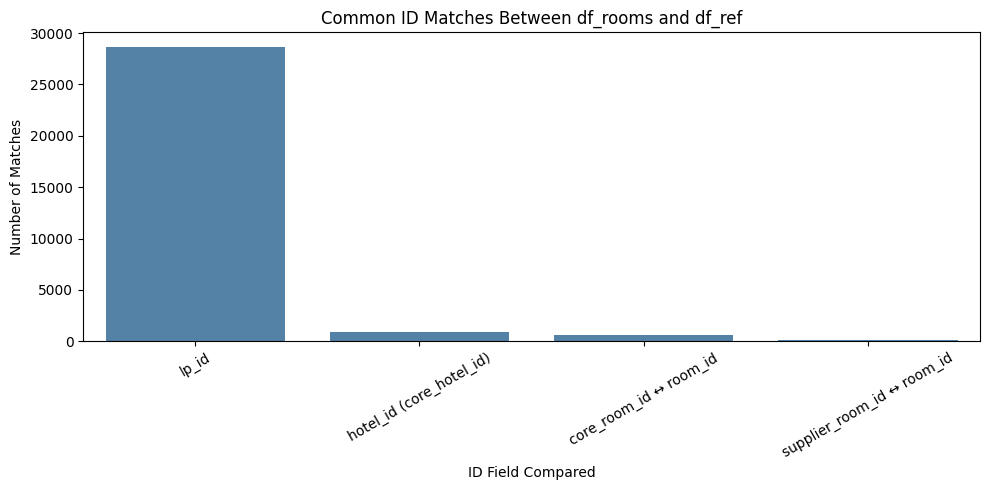

In [10]:
### looking for id matches
common_lp_ids = pd.Series(list(set(df_rooms['lp_id']) & set(df_ref['lp_id'])))
print(f"Common lp_id count: {common_lp_ids}")

common_hotel_ids = pd.Series(list(set(df_rooms['core_hotel_id']) & set(df_ref['hotel_id'])))
print(f"common hotel_id count: {common_hotel_ids}")

common_core_room_ids = pd.Series(list(set(df_rooms['core_room_id']) & set(df_ref['room_id'])))
print(f"Common room_id : {common_core_room_ids}")

common_supplier_room_ids = pd.Series(list(set(df_rooms['supplier_room_id']) & set(df_ref['room_id'])))
print(f"Common hotel_id count: {common_supplier_room_ids}")


# Count summary
match_counts = {
    'lp_id': len(common_lp_ids),
    'hotel_id (core_hotel_id)': len(common_hotel_ids),
    'core_room_id ↔ room_id': len(common_core_room_ids),
    'supplier_room_id ↔ room_id': len(common_supplier_room_ids)
}

# Print counts
print("Match Counts Summary:\n")
for k, v in match_counts.items():
    print(f"{k}: {v}")

# Convert to DataFrame for plotting
match_df = pd.DataFrame(list(match_counts.items()), columns=['ID Type', 'Match Count'])

# Barplot with no warning about palette
plt.figure(figsize=(10, 5))
sns.barplot(data=match_df, x='ID Type', y='Match Count', color='steelblue')  # use `color` instead of `palette`
plt.title("Common ID Matches Between df_rooms and df_ref")
plt.xlabel("ID Field Compared")
plt.ylabel("Number of Matches")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

In [11]:
# Load language detection model
lang_model = fasttext.load_model('../models/lid.176.bin')

# Language detection
def detect_lang(text):
    try:
        label, confidence = lang_model.predict(text.strip().replace('\n', ''))
        return label[0].replace('__label__', ''), confidence[0]
    except:
        return 'unknown', 0.0

# Detect language for supplier room names in df_rooms
df_rooms_langs = df_rooms['supplier_room_name'].dropna().apply(lambda x: detect_lang(x)[0])
rooms_lang_count = Counter(df_rooms_langs)

# Detect language for reference room names in df_ref
df_ref_langs = df_ref['room_name'].dropna().apply(lambda x: detect_lang(x)[0])
ref_lang_count = Counter(df_ref_langs)

# Display results
print("Language distribution in df_rooms (supplier room names):")
for lang, count in rooms_lang_count.most_common():
    print(f"{lang}: {count}")

print("\n Language distribution in df_ref (reference room names):")
for lang, count in ref_lang_count.most_common():
    print(f"{lang}: {count}")


Language distribution in df_rooms (supplier room names):
en: 2769588
it: 46120
fr: 12469
es: 10253
de: 9766
pt: 5996
ar: 4281
nl: 2326
ja: 1835
pl: 1059
ca: 538
sv: 471
id: 446
zh: 430
ceb: 379
tr: 343
fi: 263
ru: 255
hu: 204
eo: 164
ms: 157
no: 155
oc: 153
cs: 142
da: 113
gl: 109
eu: 101
fa: 97
uk: 80
hr: 66
ro: 58
sl: 46
la: 45
et: 43
vi: 40
th: 39
sr: 34
ko: 28
lt: 26
af: 21
sk: 21
mzn: 21
war: 18
fy: 17
sh: 14
cy: 13
az: 13
nds: 13
nn: 13
mk: 10
sq: 10
te: 9
jv: 8
br: 8
ur: 8
lv: 8
min: 7
bs: 6
als: 6
su: 6
bn: 5
ast: 5
tl: 5
vo: 4
jbo: 4
kw: 4
ml: 4
io: 4
tt: 3
mr: 3
el: 3
is: 3
ku: 3
ia: 3
sw: 3
mn: 3
my: 3
gd: 2
hy: 2
uz: 2
km: 2
pms: 2
kk: 2
hsb: 1
lb: 1
bg: 1
ie: 1
ga: 1
qu: 1
si: 1
cbk: 1
ta: 1
arz: 1
pam: 1
am: 1
rm: 1

 Language distribution in df_ref (reference room names):
en: 97479
it: 1354
fr: 372
es: 216
de: 213
pt: 104
nl: 58
ja: 27
zh: 16
ru: 15
sv: 14
id: 14
pl: 13
oc: 12
tr: 11
fi: 10
eo: 8
ca: 8
ceb: 8
fa: 7
ms: 7
hu: 5
eu: 3
cs: 3
uk: 3
ro: 3
bn: 2
da: 2
sl: 2
vi

In [13]:
df_rooms[df_rooms['lp_id'] == 'lp74c8d']

,core_room_id,core_hotel_id,lp_id,supplier_room_id,supplier_name,supplier_room_name
1457761,1460274,478349,lp74c8d,200812670,Expedia,Deluxe Double Room
1463658,1466171,478349,lp74c8d,200812753,Expedia,Deluxe Twin Room
1468699,1471212,478349,lp74c8d,229805782,Expedia,"Premier Triple Room, 3 Twin Beds"
1471686,1474199,478349,lp74c8d,202118016,Expedia,Room (Randomly assigned upon check in)
1473832,1476345,478349,lp74c8d,200812756,Expedia,Premier Twin Room
1475011,1477524,478349,lp74c8d,202176354,Expedia,"Deluxe Twin Room, 2 Double Beds (디럭스 패밀리 트윈)"
2598140,2641528,478349,lp74c8d,322489962,Expedia,Premier Family Ondol Room


In [12]:
df_ref[df_ref['lp_id'] == 'lp74c8d']

,hotel_id,lp_id,room_id,room_name
64875,2544264,lp74c8d,254426401,Single Room with Balcony
64876,2544264,lp74c8d,254426402,Double Room with Balcony
64877,2544264,lp74c8d,254426403,Triple Room with Balcony
64878,2544264,lp74c8d,254426404,Quadruple Room with Balcony
64879,2544264,lp74c8d,254426414,Economy Double Room
64880,2544264,lp74c8d,254426415,Superior Family Room
64881,2544264,lp74c8d,254426416,Villa - Beach Front


In [14]:
df_rooms[df_rooms['lp_id'] == 'lp655835e3']

,core_room_id,core_hotel_id,lp_id,supplier_room_id,supplier_name,supplier_room_name
2350656,2394044,1700279779,lp655835e3,320662691,Expedia,إستديو ديلوكس
2354917,2398305,1700279779,lp655835e3,320662463,Expedia,غرفة مزدوجة


In [15]:
df_ref[df_ref['lp_id'] == 'lp655835e3']

,hotel_id,lp_id,room_id,room_name
74793,13463994,lp655835e3,1142451754,Deluxe Studio
74794,13463994,lp655835e3,1142451769,Double Room


In [14]:
df_rooms[df_rooms['core_hotel_id'] == 628660]

,core_room_id,core_hotel_id,lp_id,supplier_room_id,supplier_name,supplier_room_name
153,154,628660,lp997b4,201691711,Expedia,"Family House, 5 Bedrooms"


In [16]:
df_ref[df_ref['hotel_id'] == 628660]

,hotel_id,lp_id,room_id,room_name
65895,628660,lp71165,62866001,Double Room
65896,628660,lp71165,62866002,Twin Room
65897,628660,lp71165,62866003,Standard Triple Room
65898,628660,lp71165,62866005,Quadruple Room
65899,628660,lp71165,62866006,Triple Room with One Double Bed and One Single...
65900,628660,lp71165,62866009,Superior Double Room


In [16]:
df_rooms[df_rooms['core_room_id'] == 1429507]

,core_room_id,core_hotel_id,lp_id,supplier_room_id,supplier_name,supplier_room_name
1426994,1429507,674747,lpa4bbb,201881189,Expedia,Deluxe Room


In [17]:
df_ref[df_ref['room_id'] == 1429507]

,hotel_id,lp_id,room_id,room_name
62113,14295,lp4d7e4,1429507,Superior Three-Bedroom Apartment


In [18]:
df_rooms[df_rooms['supplier_room_id'] == 228316703]

,core_room_id,core_hotel_id,lp_id,supplier_room_id,supplier_name,supplier_room_name
866707,869220,1700065373,lp6554f05d,228316703,Expedia,Executive Room


In [18]:
df_ref[df_ref['room_id'] == 228316703]

,hotel_id,lp_id,room_id,room_name
90958,2283167,lp6564419b,228316703,Two-Bedroom Apartment


In [20]:
# Load the multilingual SBERT model
model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

# Original mixed-language room name
room1 = "Deluxe Twin Room, 2 Double Beds (디럭스 패밀리 트윈)"

# Translated version of the Korean room name
room2_translated = "Deluxe Twin Room with two double beds"

# Encode both
embedding1 = model.encode(room1, convert_to_tensor=True)
embedding2 = model.encode(room2_translated, convert_to_tensor=True)

# Compute similarity
similarity = util.cos_sim(embedding1, embedding2).item()
print(f"Translated similarity: {similarity:.4f}")

Translated similarity: 0.9716


In [ ]:
###  This process may take 5–6 hours on MacBook Air M3 8GB

# Use GPU if available (e.g., Colab T4), otherwise CPU (MacBook M3 optimized)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2", device=device)

# Prepare result list
match_rows = []

# Iterate through df_rooms (assumes df_rooms and df_ref are already loaded)
for r in tqdm(df_rooms.itertuples(index=False), total=len(df_rooms), desc="Matching rooms"):
    
    if not isinstance(r.supplier_room_name, str):
        continue

    # Step 1: Filter matching reference candidates
    ref_candidates = df_ref[
        (df_ref['lp_id'] == r.lp_id) |
        (df_ref['hotel_id'] == r.core_hotel_id) |
        (df_ref['room_id'] == r.core_room_id) |
        (df_ref['room_id'] == r.supplier_room_id)
    ]

    if ref_candidates.empty:
        continue

    # Step 2: Embed supplier room name
    emb_room = model.encode(r.supplier_room_name, convert_to_tensor=True, device=device)

    # Step 3: Compare to each reference room
    for ref in ref_candidates.itertuples(index=False):
        if not isinstance(ref.room_name, str):
            continue

        emb_ref = model.encode(ref.room_name, convert_to_tensor=True, device=device)
        sim = float(util.cos_sim(emb_room, emb_ref).item())

        # ID match logic
        lp_match = int(r.lp_id == ref.lp_id)
        hotel_match = int(r.core_hotel_id == ref.hotel_id)
        room_match = int((r.core_room_id == ref.room_id) or (r.supplier_room_id == ref.room_id))
        id_match = (lp_match + hotel_match + room_match) > 0  # At least one match

        # Store match record
        match_rows.append({
            'core_room_id': r.core_room_id,
            'supplier_room_id': r.supplier_room_id,
            'ref_room_id': ref.room_id,
            'lp_id_match': lp_match,
            'hotel_id_match': hotel_match,
            'room_id_match': room_match,
            'cosine_sim': sim,
            'label': int(id_match and sim >= 0.85)
        })

# Convert to DataFrame
match_df = pd.DataFrame(match_rows)
match_df.head()


In [ ]:
# Use GPU if available (e.g., Colab T4), otherwise CPU (MacBook M3 optimized)

# Load multilingual SBERT model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2", device=device)

# Pre-encode supplier room names
df_rooms = df_rooms.dropna(subset=['supplier_room_name'])
df_rooms['embedding'] = model.encode(
    df_rooms['supplier_room_name'].tolist(),
    batch_size=64,
    convert_to_tensor=True,
    device=device,
    normalize_embeddings=True
)

# Pre-encode reference room names
df_ref = df_ref.dropna(subset=['room_name'])
df_ref['embedding'] = model.encode(
    df_ref['room_name'].tolist(),
    batch_size=64,
    convert_to_tensor=True,
    device=device,
    normalize_embeddings=True
)

# Build lookup tables for reference data to reduce search
ref_buckets = defaultdict(list)
for ref in tqdm(df_ref.itertuples(index=False), total=len(df_ref), desc="🔧 Indexing reference buckets"):
    ref_buckets[f"lp_{ref.lp_id}"].append(ref)
    ref_buckets[f"h_{ref.hotel_id}"].append(ref)
    ref_buckets[f"rid_{ref.room_id}"].append(ref)

# Efficient loop: compute cosine similarity and match logic
match_rows = []

for idx, r in tqdm(enumerate(df_rooms.itertuples(index=False)), total=len(df_rooms), desc="🔍 Matching rooms (optimized)"):
    candidates = (
        ref_buckets.get(f"lp_{r.lp_id}", []) +
        ref_buckets.get(f"h_{r.core_hotel_id}", []) +
        ref_buckets.get(f"rid_{r.core_room_id}", []) +
        ref_buckets.get(f"rid_{r.supplier_room_id}", [])
    )

    if not candidates:
        continue

    emb_room = r.embedding.unsqueeze(0)

    for ref in candidates:
        emb_ref = ref.embedding.unsqueeze(0)
        sim = float(util.cos_sim(emb_room, emb_ref).item())

        # ID match logic
        lp_match = int(r.lp_id == ref.lp_id)
        hotel_match = int(r.core_hotel_id == ref.hotel_id)
        room_match = int((r.core_room_id == ref.room_id) or (r.supplier_room_id == ref.room_id))
        id_match = (lp_match + hotel_match + room_match) > 0  # At least one match

        # Append match row
        match_rows.append({
            'core_room_id': r.core_room_id,
            'supplier_room_id': r.supplier_room_id,
            'ref_room_id': ref.room_id,
            'lp_id_match': lp_match,
            'hotel_id_match': hotel_match,
            'room_id_match': room_match,
            'cosine_sim': sim,
            'label': int(id_match and sim >= 0.85)
        })

# Final match dataset
match_df = pd.DataFrame(match_rows)
match_df.head()


In [8]:
# Load language detector
lang_model = fasttext.load_model('../models/lid.176.bin')

def detect_lang(text):
    label, confidence = lang_model.predict(text.strip().replace('\n', ''))
    return label[0].replace('__label__', ''), confidence[0]

# Test
print(detect_lang("Deluxe Room (ディラックス ルーム)"))  # Likely 'en' or 'ja'
print(detect_lang("غرفة ديلوكس"))                     # 'ar'


('ja', 0.9707074165344238)
('ar', 0.9998712539672852)


In [51]:
# Load language detection model
lang_model = fasttext.load_model('../models/lid.176.bin')

# Language detection
def detect_lang(text):
    try:
        label, confidence = lang_model.predict(text.strip().replace('\n', ''))
        return label[0].replace('__label__', ''), confidence[0]
    except:
        return 'unknown', 0.0

# Normalize text
def normalize(text):
    if not isinstance(text, str):
        return ''
    text = text.lower()
    text = unicodedata.normalize('NFD', text)
    text = ''.join(c for c in text if unicodedata.category(c) != 'Mn')  # Remove accents
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text.strip()

# Fuzzy match
def fast_match(name1, name2):
    return partial_ratio(normalize(name1), normalize(name2)) / 100.0

# Pre-bucket reference data
ref_buckets = defaultdict(list)
for ref in df_ref.itertuples(index=False):
    ref_buckets[f"lp_{ref.lp_id}"].append(ref)
    ref_buckets[f"h_{ref.hotel_id}"].append(ref)
    ref_buckets[f"rid_{ref.room_id}"].append(ref)

# Match generation loop
match_rows = []

for r in tqdm(df_rooms.itertuples(index=False), total=len(df_rooms), desc="Multilingual fuzzy matching"):
    
    if not isinstance(r.supplier_room_name, str):
        continue

    lang_supplier, conf_supplier = detect_lang(r.supplier_room_name)

    # Collect candidate refs
    candidates = (
        ref_buckets.get(f"lp_{r.lp_id}", []) +
        ref_buckets.get(f"h_{r.core_hotel_id}", []) +
        ref_buckets.get(f"rid_{r.core_room_id}", []) +
        ref_buckets.get(f"rid_{r.supplier_room_id}", [])
    )

    if not candidates:
        continue

    for ref in candidates:
        if not isinstance(ref.room_name, str):
            continue

        sim = fast_match(r.supplier_room_name, ref.room_name)
        lang_ref, conf_ref = detect_lang(ref.room_name)

        # ID match logic
        lp_match = int(r.lp_id == ref.lp_id)
        hotel_match = int(r.core_hotel_id == ref.hotel_id)
        room_match = int((r.core_room_id == ref.room_id) or (r.supplier_room_id == ref.room_id))
        id_match = (lp_match + hotel_match + room_match) > 0  # At least one ID match

        match_rows.append({
            'core_room_id': r.core_room_id,
            'supplier_room_id': r.supplier_room_id,
            'ref_room_id': ref.room_id,
            'lp_id_match': lp_match,
            'hotel_id_match': hotel_match,
            'room_id_match': room_match,
            'fuzzy_score': sim,
            'label': int(id_match and sim >= 0.85),
            'supplier_room_name': r.supplier_room_name,
            'ref_room_name': ref.room_name,
            'lang_supplier': lang_supplier,
            'lang_ref': lang_ref,
            'lang_conf_supplier': conf_supplier,
            'lang_conf_ref': conf_ref
        })


Multilingual fuzzy matching: 100%|██████████| 2869056/2869056 [00:32<00:00, 88807.50it/s] 


In [52]:
match_df = pd.DataFrame(match_rows)
match_df

,core_room_id,supplier_room_id,ref_room_id,lp_id_match,hotel_id_match,room_id_match,fuzzy_score,label,supplier_room_name,ref_room_name,lang_supplier,lang_ref,lang_conf_supplier,lang_conf_ref
0,2,200998017,1142485350,1,0,0,1.000000,1,"Deluxe Room, Balcony","Deluxe Room, Balcony",en,en,0.513417,0.513417
1,2,200998017,1142486049,1,0,0,0.500000,0,"Deluxe Room, Balcony",Standard Room,en,en,0.513417,0.491843
2,5,218116045,1143483374,1,0,0,1.000000,1,"Traditional Cottage, 2 Bedrooms, Harbor View","Traditional Cottage, 2 Bedrooms, Harbor View",en,en,0.720920,0.720920
3,7,201681924,1143605967,1,0,0,1.000000,1,"Comfort House, 6 Bedrooms, Ocean View","Comfort House, 6 Bedrooms, Ocean View",en,en,0.722728,0.722728
4,7,201681924,1143606069,1,0,0,1.000000,1,"Comfort House, 6 Bedrooms, Ocean View","Comfort House, 6 Bedrooms, Ocean View",en,en,0.722728,0.722728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
454375,2912430,323988775,1142771976,1,0,0,0.625000,0,Mongomo King Suite,"Superior Room, 1 King Bed",en,en,0.249305,0.600396
454376,2912430,323988775,1142771978,1,0,0,0.761905,0,Mongomo King Suite,Guinea Suite,en,en,0.249305,0.401564
454377,2912430,323988775,1142772003,1,0,0,1.000000,1,Mongomo King Suite,Suite,en,en,0.249305,0.347625
454378,2912430,323988775,1142772018,1,0,0,0.705882,0,Mongomo King Suite,Oyala Suite,en,en,0.249305,0.284905


In [53]:
print(match_df['label'].value_counts())

label
0    343818
1    110562
Name: count, dtype: int64



#### fuzzy_score: 0.75
    label
    label
    0    292355
    1    162025


#### fuzzy_score: 0.85
    label
    0    343818
    1    110562


#### fuzzy_score: 0.95
    label
    0    375392
    1     78988


#### fuzzy_score: 1.00
    label
    0    385085
    1     69295

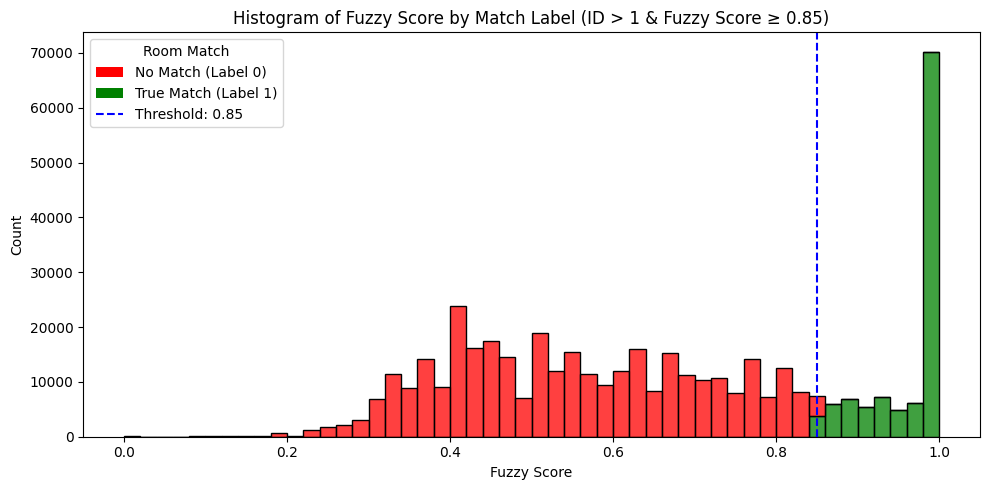

In [54]:
# Assuming match_df is already loaded with necessary columns
# We'll simulate a sample structure to demonstrate the visualizations

# Convert match_type to string if not already
match_df['match_type'] = match_df.apply(
    lambda x: f"{int((x['lp_id_match'] + x['hotel_id_match'] + x['room_id_match']) > 1)}_ID_" +
              f"{int(x['fuzzy_score'] >= 0.85)}_score",
    axis=1
)

# Histogram
import matplotlib.pyplot as plt
import seaborn as sns

# Create the histogram
plt.figure(figsize=(10, 5))
sns.histplot(
    data=match_df, 
    x='fuzzy_score', 
    hue='label', 
    bins=50, 
    multiple='stack', 
    palette={0: 'red', 1: 'green'}, 
    stat='count'
)

# Add threshold line
plt.axvline(0.85, color='blue', linestyle='--', label='Threshold: 0.85')

# Customize plot
plt.title("Histogram of Fuzzy Score by Match Label (ID > 1 & Fuzzy Score ≥ 0.85)")
plt.xlabel("Fuzzy Score")
plt.ylabel("Count")

# Custom legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='red', label='No Match (Label 0)'),
    Patch(facecolor='green', label='True Match (Label 1)'),
    Line2D([0], [0], color='blue', linestyle='--', label='Threshold: 0.85')
]
plt.legend(handles=legend_elements, title="Room Match")

plt.tight_layout()
plt.show()


match_type
001       688
010     19527
100    434165
Name: count, dtype: int64


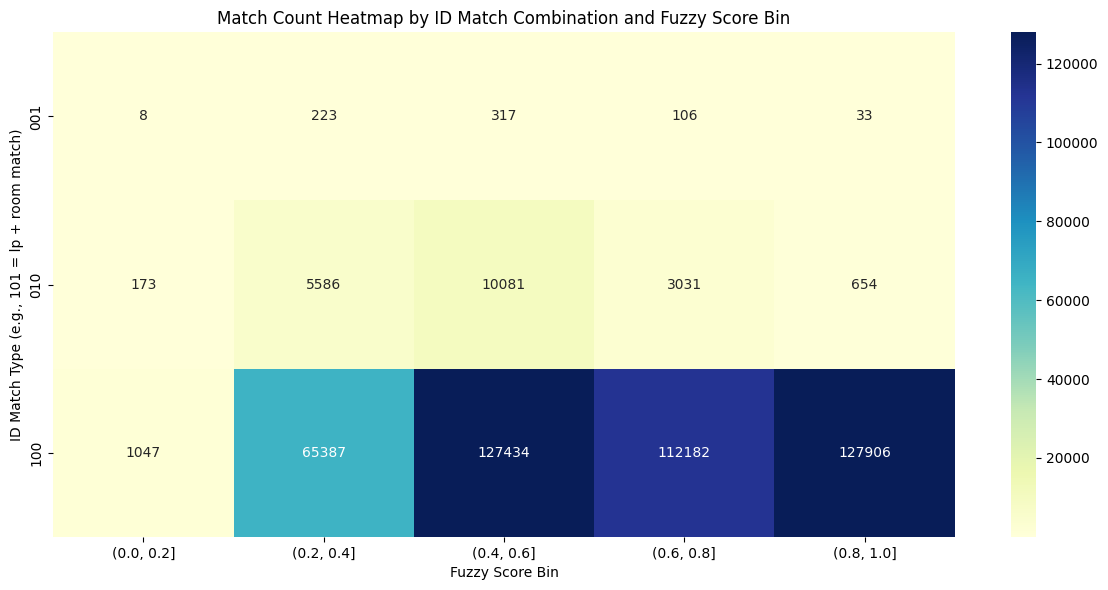

In [55]:
# Heatmap
# Make match_type a string like '100', '011', etc.
match_df['match_type'] = match_df.apply(
    lambda x: f"{x['lp_id_match']}{x['hotel_id_match']}{x['room_id_match']}", axis=1
)

# Count occurrences
match_type_counts = match_df['match_type'].value_counts().sort_index()
print(match_type_counts)

match_df['fuzzy_bin'] = pd.cut(match_df['fuzzy_score'], bins=np.linspace(0, 1, 6))
heatmap_data = match_df.groupby(['match_type', 'fuzzy_bin'], observed=True).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap="YlGnBu")
plt.title("Match Count Heatmap by ID Match Combination and Fuzzy Score Bin")
plt.xlabel("Fuzzy Score Bin")
plt.ylabel("ID Match Type (e.g., 101 = lp + room match)")
plt.tight_layout()
plt.show()


In [56]:

# Load match_df (simulating your data structure)

# Define features and target
features = ['lp_id_match', 'hotel_id_match', 'room_id_match', 'fuzzy_score']
target = 'label'

X = match_df[features]
y = match_df[target]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define Optuna objective
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'eval_metric': 'logloss',
        'use_label_encoder': False
    }

    model = XGBClassifier(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return f1_score(y_test, preds)

# Run Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# Best model
best_params = study.best_params
best_params['eval_metric'] = 'logloss'
best_params['use_label_encoder'] = False

model = XGBClassifier(**best_params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Evaluation Metrics
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

# Classification report
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

print(report_df.round(2))

# Save model
joblib.dump(model, '../models/model.pkl')

[I 2025-04-19 19:16:36,941] A new study created in memory with name: no-name-d622e2e6-3ebf-4aaa-aede-356db77ce4be
[I 2025-04-19 19:16:38,316] Trial 0 finished with value: 0.9968134019210634 and parameters: {'learning_rate': 0.17105393235184896, 'max_depth': 8, 'n_estimators': 420, 'subsample': 0.6505410317863148, 'colsample_bytree': 0.6793425749913957}. Best is trial 0 with value: 0.9968134019210634.
[I 2025-04-19 19:16:38,850] Trial 1 finished with value: 0.9968134019210634 and parameters: {'learning_rate': 0.2854715501430534, 'max_depth': 7, 'n_estimators': 152, 'subsample': 0.76613553304739, 'colsample_bytree': 0.5421564766596455}. Best is trial 0 with value: 0.9968134019210634.
[I 2025-04-19 19:16:39,899] Trial 2 finished with value: 0.9968134019210634 and parameters: {'learning_rate': 0.27041180707829765, 'max_depth': 9, 'n_estimators': 335, 'subsample': 0.9653628272087318, 'colsample_bytree': 0.6377621880637101}. Best is trial 0 with value: 0.9968134019210634.
[I 2025-04-19 19:16

              precision  recall  f1-score  support
0                   1.0    1.00       1.0  68839.0
1                   1.0    0.99       1.0  22037.0
accuracy            1.0    1.00       1.0      1.0
macro avg           1.0    1.00       1.0  90876.0
weighted avg        1.0    1.00       1.0  90876.0


['../models/model.pkl']

#### fuzzy_score 0.75
                precision  recall  f1-score  support
    0                   1.0     1.0       1.0  58534.0
    1                   1.0     1.0       1.0  32342.0
    accuracy            1.0     1.0       1.0      1.0
    macro avg           1.0     1.0       1.0  90876.0
    weighted avg        1.0     1.0       1.0  90876.0


#### fuzzy_score 0.85
                  precision  recall  f1-score  support
    0                   1.0    1.00       1.0  68839.0
    1                   1.0    0.99       1.0  22037.0
    accuracy            1.0    1.00       1.0      1.0
    macro avg           1.0    1.00       1.0  90876.0
    weighted avg        1.0    1.00       1.0  90876.0
                precision  recall  f1-score  support


#### fuzzy_score 0.95
                  precision  recall  f1-score  support
    0                   1.0    1.00       1.0  75169.0
    1                   1.0    0.99       1.0  15707.0
    accuracy            1.0    1.00       1.0      1.0
    macro avg           1.0    1.00       1.0  90876.0
    weighted avg        1.0    1.00       1.0  90876.0



#### fuzzy_score 0.95
                  precision  recall  f1-score  support
    0                   1.0     1.0       1.0  77103.0
    1                   1.0     1.0       1.0  13773.0
    accuracy            1.0     1.0       1.0      1.0
    macro avg           1.0     1.0       1.0  90876.0
    weighted avg        1.0     1.0       1.0  90876.0


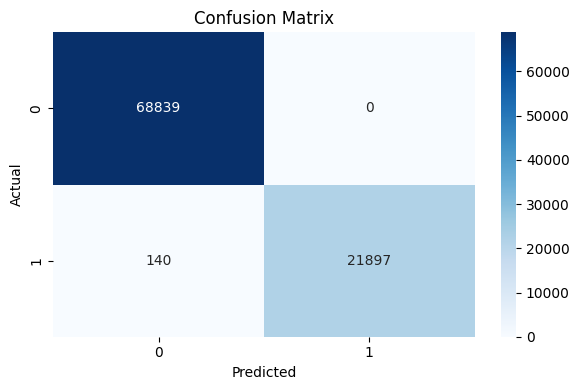

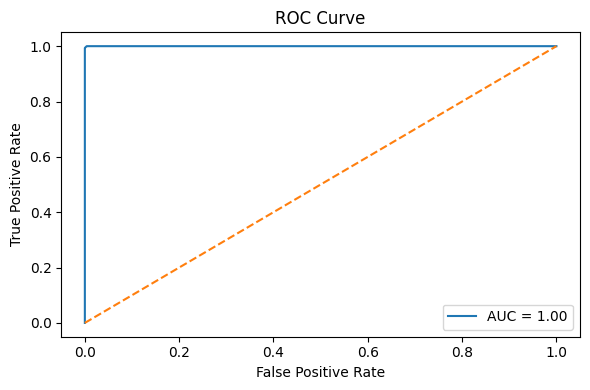

In [57]:
# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()


In [58]:
# Merge room names for better interpretability
match_df = match_df.merge(df_rooms[['core_room_id', 'supplier_room_id', 'supplier_room_name']], on=['core_room_id', 'supplier_room_id'], how='left')
match_df = match_df.merge(df_ref[['room_id', 'room_name']], left_on='ref_room_id', right_on='room_id', how='left')
match_df = match_df.rename(columns={'supplier_room_name': 'supplier_name', 'room_name': 'reference_name'})

# Show top matches and non-matches for human checking
sample_matches = match_df[(match_df['label'] == 1) & (match_df['fuzzy_score'] > 0.85)].sample(3, random_state=42)
sample_non_matches = match_df[(match_df['label'] == 0) & (match_df['fuzzy_score'] < 0.6)].sample(3, random_state=42)

tools.display_dataframe_to_user(name="Top Match Examples with Room Names", dataframe=sample_matches)
tools.display_dataframe_to_user(name="Top Non-Match Examples with Room Names", dataframe=sample_non_matches)

report_df.round(2)

Top Match Examples with Room Names


Top Non-Match Examples with Room Names


,precision,recall,f1-score,support
0,1.0,1.00,1.0,68839.0
1,1.0,0.99,1.0,22037.0
accuracy,1.0,1.00,1.0,1.0
macro avg,1.0,1.00,1.0,90876.0
weighted avg,1.0,1.00,1.0,90876.0
